<H1>Лабораторная работа №4</H1>

<H3>Ким Д.А. 5130901/10201</H3>

<H3>Упражнение 4.1</H3>
Возьмем несколько звуков и сравним их спектры с различными шумами.

In [2]:
import thinkdsp
import math
import numpy as np

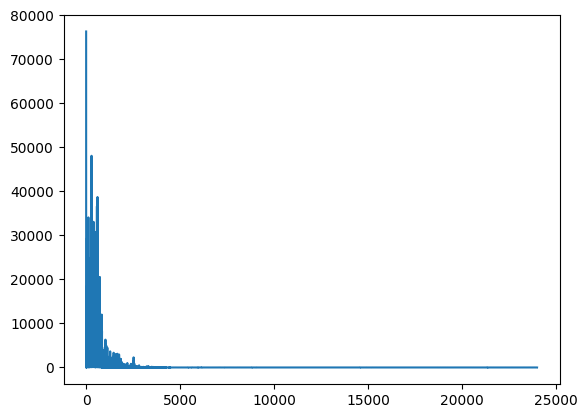

In [3]:
crowdWave = thinkdsp.read_wave('sounds/crowd.wav')
crowdWave.make_audio()
crowdSegment = crowdWave.segment(start=1, duration=1)
crowdSegment.make_spectrum().plot_power()

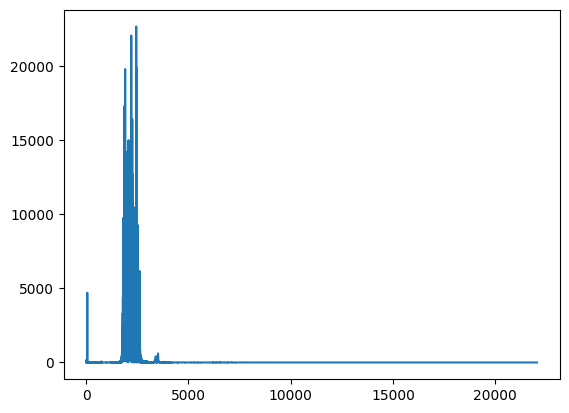

In [4]:
morningWave = thinkdsp.read_wave('sounds/morning.wav')
morningWave.make_audio()
morningSegment = morningWave.segment(start=1, duration=1)
morningSegment.make_spectrum().plot_power()

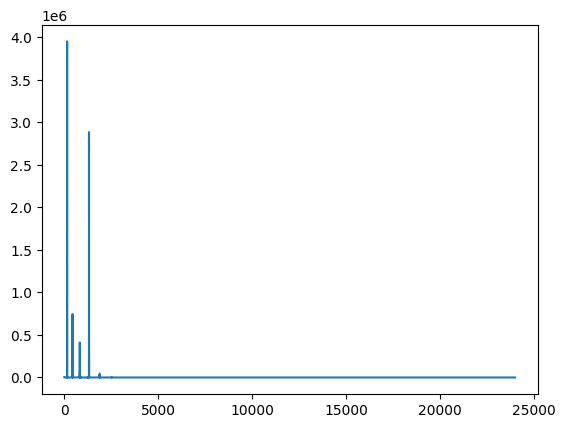

In [5]:
bowlWave = thinkdsp.read_wave('sounds/bowl.wav')
bowlWave.make_audio()
bowlSegment = bowlWave.segment(start=2, duration=1)
bowlSegment.make_spectrum().plot_power()

Амплитуда сильно уменьшается с частотой, что похоже на красный шум.

<H3>Упражнение 4.2</H3>

Реализуем метод Бартлетта для оценки спектра мощности шумового сигнала.

In [6]:
def bartlett_method(wave, seg_length=512, win_flag=True):
    spectrum = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectrum.spec_map.values()
    psds = [sp.power for sp in spectrums]
    
    # compute the root mean power (which is like an amplitude)
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs
    
    # make a Spectrum with the mean amplitudes
    spec = thinkdsp.Spectrum(hs, fs, wave.framerate)
    return spec

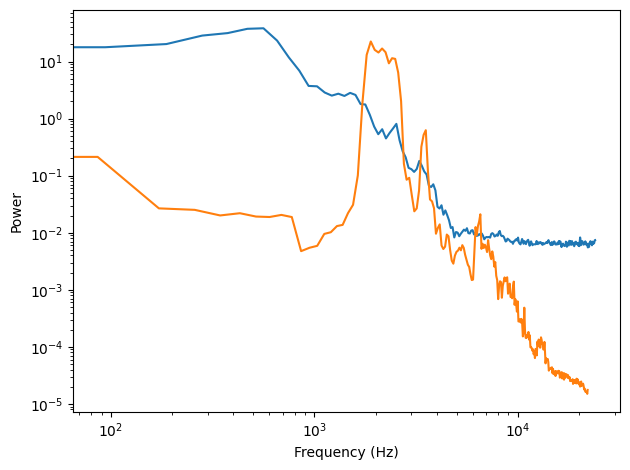

In [9]:
psd = bartlett_method(crowdSegment)
psd2 = bartlett_method(morningSegment)

psd.plot_power()
psd2.plot_power()
loglog = dict(xscale='log', yscale='log')

thinkdsp.decorate(xlabel='Frequency (Hz)', 
         ylabel='Power', 
         **loglog)

Можно наблюдать нелинейную зависимость между частотой и мощностью.

<H3>Упражнение 4.3</H3>

Вычислим спектр цен биткоин.

In [17]:
import pandas as pd

df = pd.read_csv('../code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv', 
                 parse_dates=[0])
df

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.654990,124.304660,124.751660,122.563490
1,BTC,2013-10-02,125.455000,123.654990,125.758500,123.633830
2,BTC,2013-10-03,108.584830,125.455000,125.665660,83.328330
3,BTC,2013-10-04,118.674660,108.584830,118.675000,107.058160
4,BTC,2013-10-05,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...,...
2354,BTC,2020-03-22,5884.340133,6187.042146,6431.873162,5802.553402
2355,BTC,2020-03-23,6455.454688,5829.352511,6620.858253,5694.198299
2356,BTC,2020-03-24,6784.318011,6455.450650,6863.602196,6406.037439
2357,BTC,2020-03-25,6706.985089,6784.325204,6981.720386,6488.111885


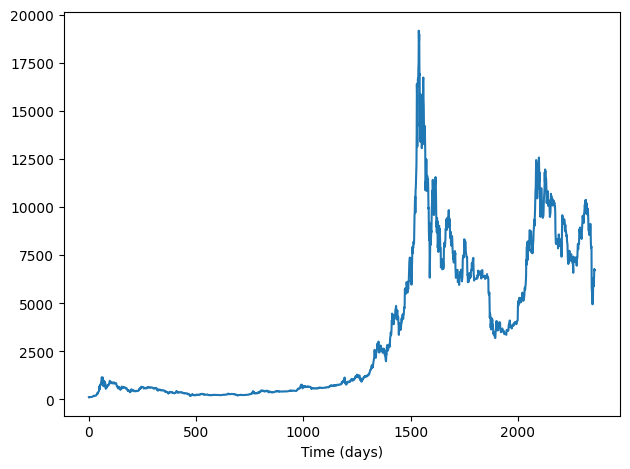

In [18]:
prices = df['Closing Price (USD)']
days = df.index
bitcoinWave = thinkdsp.Wave(prices, days, framerate=1)
bitcoinWave.plot()
thinkdsp.decorate(xlabel='Time (days)')

Данный график напоминает розовый шум.

<H3>Упражнение 4.4</H3>

Создадим класс, который будет генерировать Пуассонов шум. 

In [20]:
class UncorrelatedPoissonNoise(thinkdsp.Noise):
    def evaluate(self, ts):
        ys = np.random.poisson(self.amp, len(ts))
        return ys

In [22]:
amp = 0.001
framerate = 10000
duration = 1

geigerSignal = UncorrelatedPoissonNoise(amp=amp)
geigerWave = geigerSignal.make_wave(duration=duration, framerate=framerate)
geigerWave.make_audio()


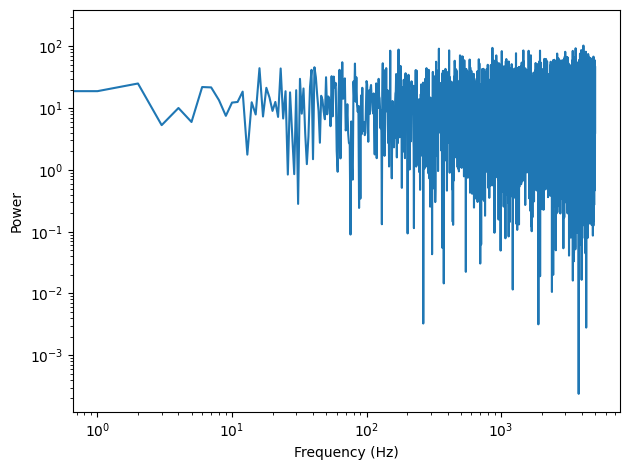

In [23]:
geigerSpectrum = geigerWave.make_spectrum()
geigerSpectrum.plot_power()
thinkdsp.decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Теперь попробуем большие значения amp. Результат должен быть похож на белый шум.

In [24]:

whiteSignal = UncorrelatedPoissonNoise(amp=0.1)
whiteWave = whiteSignal.make_wave(duration=duration, framerate=framerate)
whiteWave.make_audio()


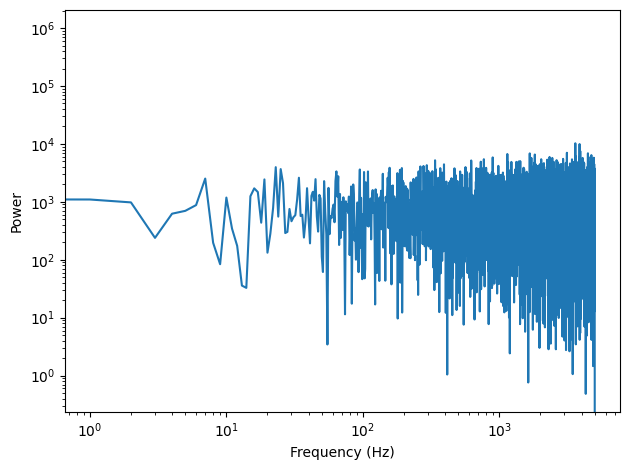

In [25]:
whiteSpectrum = whiteWave.make_spectrum()
whiteSpectrum.plot_power()
thinkdsp.decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Сигнал звучит как белый шум и график мощности также соответствует белому шуму.

<H3>Упражнение 4.5</H3>

Реализуем алгоритм для генерации розового шума Voss-McCartney. Протестируем его и убедимся, что получаемый результат корректный.

In [26]:
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    cols = np.random.geometric(0.5, nrows)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=nrows)
    array[rows, cols] = np.random.random(nrows)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

C:\Users\kanea\AppData\Local\Temp\ipykernel_15096\2967607798.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)


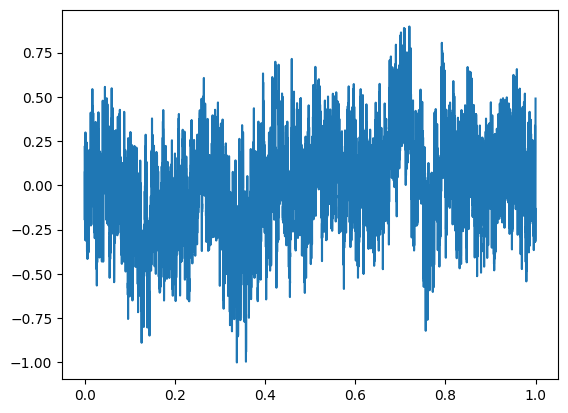

In [27]:
ys = voss(11025)
vossWave = thinkdsp.Wave(ys)
vossWave.unbias()
vossWave.normalize()
vossWave.plot()
vossWave.make_audio()

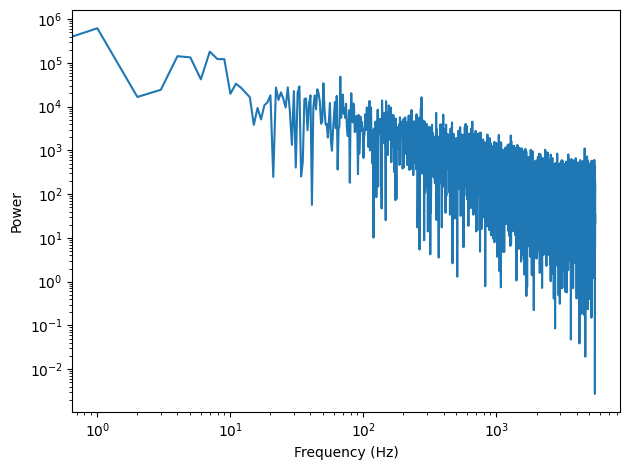

In [29]:
vossSpectrum = vossWave.make_spectrum()
vossSpectrum.hs[0] = 0
vossSpectrum.plot_power()
thinkdsp.decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Видим, что результаты соответсвуют ожидаемым.